In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your real dataset
df = pd.read_csv("/Users/erikborn/Documents/Python/jupyter/Salary_ML/mlData2.csv")

# Convert Hire Date to datetime and calculate years since hire
df["Hire Date "] = pd.to_datetime(df["Hire Date "], errors="coerce")
df["Years Since Hire"] = pd.Timestamp("2024-01-01") - df["Hire Date "]
df["Years Since Hire"] = df["Years Since Hire"].dt.days // 365
df = df.drop(columns=["Hire Date "])

# Drop rows with missing salary or predictors
df["25-26 Salary"] = pd.to_numeric(df["25-26 Salary"].str.replace(",", ""), errors="coerce")
df["Prep Rating"] = pd.to_numeric(df["Prep Rating"], errors="coerce")
df = df.dropna(subset=["25-26 Salary"])
df = df.dropna()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(
    df,
    columns=["Ethnicity", "Gender", "Education Level"],
    drop_first=True
)

# Separate features and target
X = df_encoded.drop(columns=["25-26 Salary"])
y = df_encoded["25-26 Salary"]

# Set up cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Tune alpha values
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
print("\n🧪 Ridge Regression Cross-Validation Results:")
print("Alpha\tAvg R²\t\tStd R²\t\tAvg RMSE\t\tStd RMSE")
for a in alphas:
    model = Ridge(alpha=a)
    scores = cross_validate(
        model,
        X,
        y,
        cv=rkf,
        scoring=('r2', 'neg_mean_squared_error'),
        return_train_score=False
    )
    r2_scores = scores["test_r2"]
    rmse_scores = (-scores["test_neg_mean_squared_error"]) ** 0.5
    print(f"{a:<6}\t{np.mean(r2_scores):.4f}\t\t{np.std(r2_scores):.4f}\t\t{np.mean(rmse_scores):,.2f}\t\t{np.std(rmse_scores):,.2f}")

# Train/test split (80/20) for final check
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = Ridge(alpha=1.0)
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = best_model.predict(X_test)

print("\n📊 Final Model Evaluation (alpha=1.0):")
print("R² score (test):", r2_score(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE (test):", rmse)


🧪 Ridge Regression Cross-Validation Results:
Alpha	Avg R²		Std R²		Avg RMSE		Std RMSE
0.01  	0.5586		0.1876		5,865.40		1,006.18
0.1   	0.5698		0.1864		5,782.53		971.35
1.0   	0.5853		0.1922		5,654.74		976.99
10.0  	0.5714		0.2158		5,714.80		956.36
100.0 	0.5721		0.2086		5,720.91		901.62

📊 Final Model Evaluation (alpha=1.0):
R² score (test): 0.6625626832419167
RMSE (test): 5548.7339193933685


In [123]:
# Store original row indices for tracking
df_encoded["__index__"] = df.index  # keep link to original unencoded DataFrame

# Prepare inputs
X = df_encoded.drop(columns=["25-26 Salary"])
y = df_encoded["25-26 Salary"]
X["__index__"] = df_encoded["__index__"]  # add index to X for tracking

# Run 100 randomized splits
split_results = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=i
    )
    model = Ridge(alpha=1)
    model.fit(X_train.drop(columns="__index__"), y_train)
    y_pred = model.predict(X_test.drop(columns="__index__"))
    r2 = r2_score(y_test, y_pred)
    split_results.append((i, r2, X_test["__index__"], model))

# Identify the worst split
split_results.sort(key=lambda x: x[1])
worst_seed, worst_r2, worst_indices, worst_model = split_results[0]

print(f"❗Worst R² out of 100 splits: {worst_r2:.4f} (random_state={worst_seed})")
print(f"\n🔍 Showing original rows for the test set from the worst split:")

# Show original rows from df using the index
worst_rows = df.loc[worst_indices]
print(worst_rows.head(10))  # or remove `.head(10)` to print all

# Optional: store for further analysis
# worst_rows.to_csv("worst_split_rows.csv", index=False)

❗Worst R² out of 100 splits: -2.0603 (random_state=49)

🔍 Showing original rows for the test set from the worst split:
    25-26 Salary Ethnicity Gender  Years of Exp  Seniority Education Level  \
28         70013         W      F             9       10.0              MA   
34         64318         W      M            19        5.0              BA   
53         73997         W      F            17        2.0              MA   
25         69205         W      F             8        7.0              MA   
36         67220         W      F            11        1.0              BA   
31         70890         A      F             6        0.0              MA   
19         66028         W      F             7        2.0              MA   
23         68119         W      F             7       12.0              MA   
42         69848         H      M            15        0.0              MA   
27         69848         W      F             7        0.0              MA   

    Skill Rating  Know

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Drop __index__ from features before prediction
X_predict = X.drop(columns="__index__") if "__index__" in X.columns else X

# Define outliers as those where the prediction is off by more than 8% of the actual salary
threshold_percent = 0.05  # 8%

df["Prediction"] = model.predict(X_predict)
df["Residual"] = df["25-26 Salary"] - df["Prediction"]
df["Outlier_Flag"] = df["Residual"].abs() > (threshold_percent * df["25-26 Salary"])

# Now prepare for classification modeling
X_class = X_predict.copy()  # no __index__ here
y_class = df["Outlier_Flag"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict probability of being an outlier
probs = clf.predict_proba(X_test)[:, 1]
custom_threshold = 0.3  # More sensitive
y_custom = probs > custom_threshold

# Evaluate
print("📊 Outlier Classifier Performance (custom threshold):")
print(classification_report(y_test, y_custom))

📊 Outlier Classifier Performance (custom threshold):
              precision    recall  f1-score   support

       False       1.00      0.12      0.22         8
        True       0.42      1.00      0.59         5

    accuracy                           0.46        13
   macro avg       0.71      0.56      0.41        13
weighted avg       0.78      0.46      0.36        13



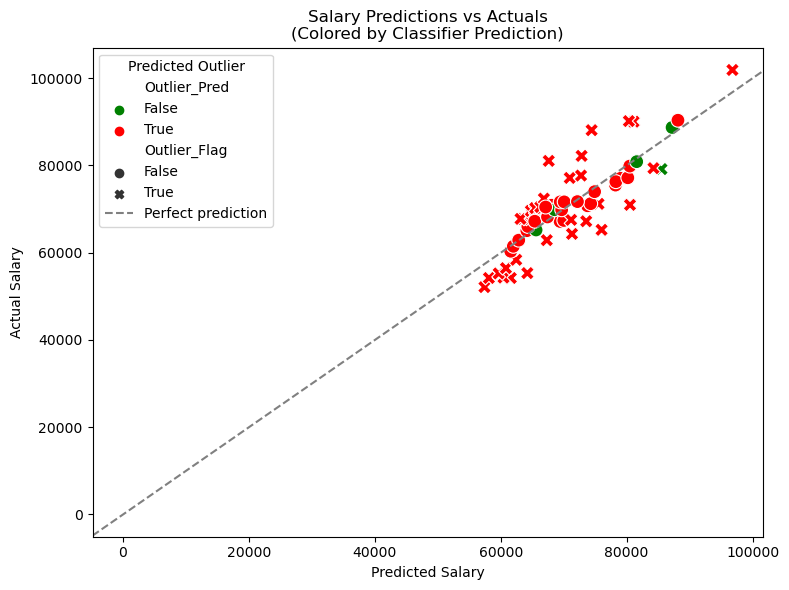

In [115]:
# Get classifier predictions on the full dataset
probs_full = clf.predict_proba(X_class)[:, 1]
df["Outlier_Prob"] = probs_full
df["Outlier_Pred"] = probs_full > 0.3  # Use same threshold as before

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Prediction",
    y="25-26 Salary",
    hue="Outlier_Pred",
    palette={True: "red", False: "green"},
    style="Outlier_Flag",  # This shows true outliers vs. model guesses
    markers={True: "X", False: "o"},
    s=100
)
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="Perfect prediction")
plt.title("Salary Predictions vs Actuals\n(Colored by Classifier Prediction)")
plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.legend(title="Predicted Outlier")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Model Confidence vs. Prediction Error')

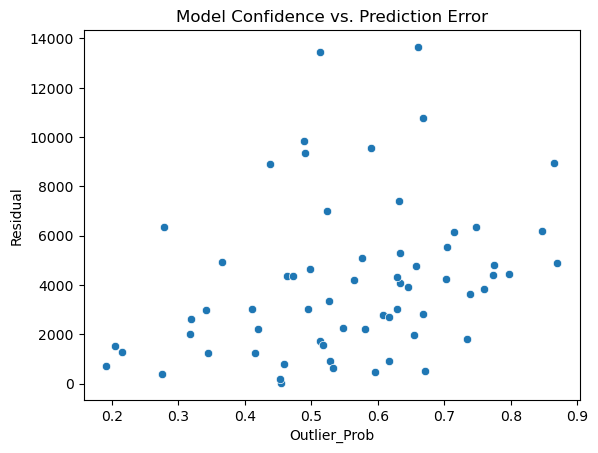

In [121]:
review_set = df[df["Outlier_Pred"] == True].copy()
review_set["Residual %"] = (df["Residual"] / df["25-26 Salary"]).abs()
review_set = review_set.sort_values("Residual %", ascending=False)
# Pick columns you want in the HR review file
cols_to_export = [
    "25-26 Salary", "Prediction", "Residual", "Residual %",
    "Outlier_Prob", "Outlier_Flag", "Outlier_Pred",
    "Years of Exp", "Seniority", "Education Level", "Gender", "Ethnicity"
]

# Export review list
review_set[cols_to_export].to_csv("hr_review_list.csv", index=False)

sns.scatterplot(data=df, x="Outlier_Prob", y=df["Residual"].abs())
plt.title("Model Confidence vs. Prediction Error")

In [112]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print(coef_df)

ValueError: All arrays must be of the same length

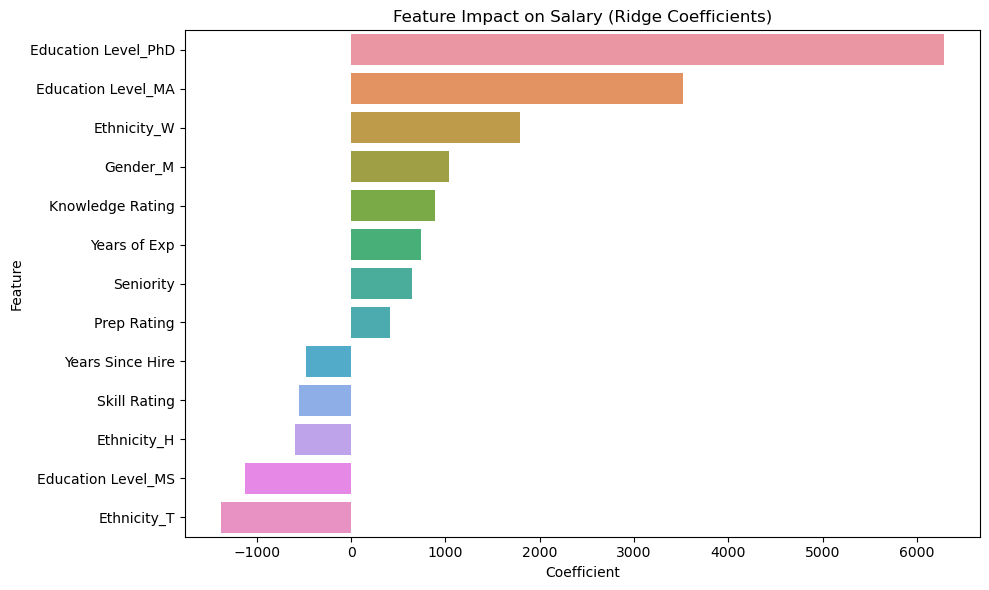

In [91]:
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x="Coefficient", y="Feature")
plt.title("Feature Impact on Salary (Ridge Coefficients)")
plt.tight_layout()
plt.show()

In [75]:
new_employee = {
    "Years of Exp": 1,
    "Seniority": 0,
    "Skill Rating": 5,
    "Knowledge Rating": 5,
    "Years Since Hire": 1,
    "Ethnicity_W": 1,
    "Gender_M": 1,
    "Education Level_MA": 1,
    "Prep Rating_1": 0,  # If multiple prep values exist
    # ... include all other one-hot encoded fields, default to 0 if not active
}

new_X = pd.DataFrame([new_employee], columns=X.columns).fillna(0)
predicted_salary = model.predict(new_X)[0]
print(f"Predicted Salary: ${predicted_salary:,.2f}")

Predicted Salary: $61,415.56


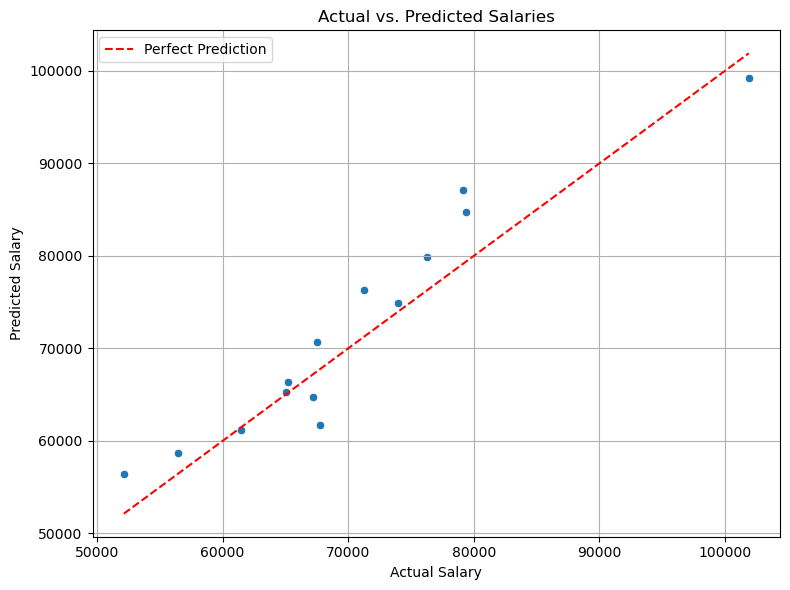

In [76]:
#Running against the reserved training sample only (how'd we do?)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)

# Reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

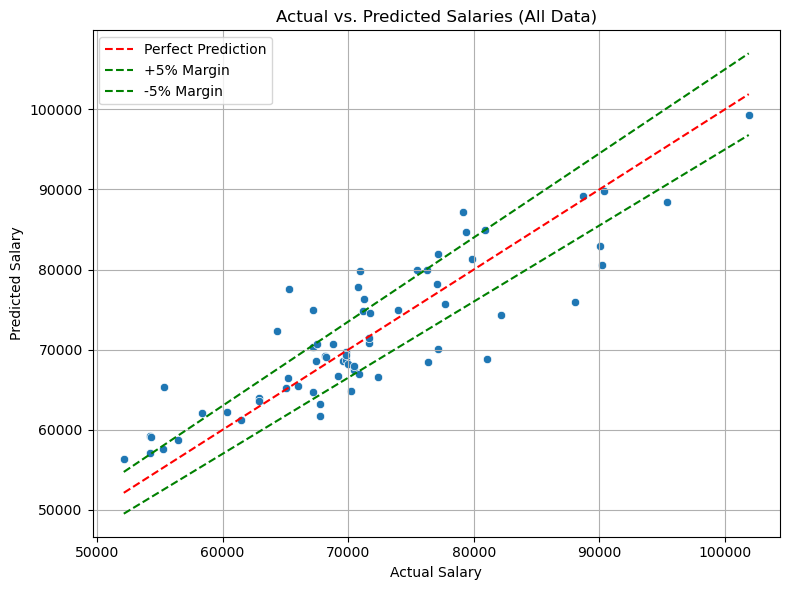

In [77]:
#Running for all data
# Predict using the full dataset
y_all_pred = model.predict(X)

# Plot actual vs predicted salaries for all data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_all_pred)

# Reference line for perfect prediction
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect Prediction")

# ±5% bands
plt.plot([y.min(), y.max()], [y.min() * 1.05, y.max() * 1.05], 'g--', label="+5% Margin")
plt.plot([y.min(), y.max()], [y.min() * 0.95, y.max() * 0.95], 'g--', label="-5% Margin")

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (All Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()